# Importing, Linking, and Cleaning the Data

In [1]:
# Import the necessary packages / libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mstats

sns.set_style('darkgrid')

In [2]:
# Import and name the relevant data

imdb_title_basics_df = pd.read_csv("Data/imdb.title.basics.csv.gz")
imdb_title_ratings_df = pd.read_csv("Data/imdb.title.ratings.csv.gz")

movie_gross_df = pd.read_csv("Data/bom.movie_gross.csv.gz")

movie_info_df = pd.read_csv("Data/tmdb.movies.csv.gz")

In [3]:
# Get a sense of datasets

print("Box office Mojo: ", len(movie_gross_df))
print("The Movie Data Base: ", len(movie_info_df))
print("IMDB Ratings table: ", len(imdb_title_ratings_df))
print("IMDB Basics table: ", len(imdb_title_basics_df))

Box office Mojo:  3387
The Movie Data Base:  26517
IMDB Ratings table:  73856
IMDB Basics table:  146144


In [4]:
# Link IMDB datasets

# Set indices

imdb_title_basics_df.set_index('tconst', inplace=True)
imdb_title_ratings_df.set_index('tconst', inplace=True)

# Join the datasets

imdb_joined_df = imdb_title_ratings_df.merge(imdb_title_basics_df, on='tconst', how='inner')

# Look at data

print("Joined table: ", len(imdb_joined_df))
print("Ratings table: ", len(imdb_title_ratings_df))
print("Basics table: ", len(imdb_title_basics_df))

Joined table:  73856
Ratings table:  73856
Basics table:  146144


# Create our two functional dataframes

In [5]:
# Link the IMDB dataset and the movie gross dataset

joined_df = movie_gross_df.merge(imdb_joined_df, left_on = 'title', right_on='primary_title', how='inner')

# Link the movie gross dataset and the movie info dataset (for seasonal anaylsis)

movie_gross_date_df = movie_gross_df.merge(movie_info_df, on='title', how='inner')


In [6]:
# Check size of Dataframes

print("Joined dataset: ", len(joined_df))
print("Revenue with date dataset: ", len(movie_gross_date_df))

print("Movie info dataset: ", len(movie_info_df))
print("IMDB dataset: ", len(imdb_joined_df))
print("Revenue dataset: ", len(movie_gross_df))

Joined dataset:  3027
Revenue with date dataset:  2703
Movie info dataset:  26517
IMDB dataset:  73856
Revenue dataset:  3387


# Clean up IMDB Ratings/Genres DF

In [7]:
# Organize and clean-up columns

joined_df.drop(columns='primary_title', inplace=True)
joined_df.set_index('title', inplace=True)

joined_df['foreign_gross'].isnull().sum()
joined_df['foreign_gross'] = pd.to_numeric(joined_df['foreign_gross'], errors='coerce')
joined_df['total_gross'] = joined_df['domestic_gross'] + joined_df['foreign_gross']
joined_df.dropna(subset=['genres'], inplace=True)

joined_df.drop(columns=['studio','original_title','start_year',
                        'domestic_gross', 'foreign_gross', 'runtime_minutes'], axis=1, inplace=True)

joined_df['total_gross'].isna().sum()
joined_df.dropna(subset=['total_gross'],inplace=True)

# Cut top 2%

x_new = mstats.winsorize(joined_df['total_gross'], limits=[0, 0.02])
joined_df['total_gross_win'] = x_new

joined_df.head(3)

,year,averagerating,numvotes,genres,total_gross,total_gross_win
title,,,,,,
Toy Story 3,2010,8.3,682218,"Adventure,Animation,Comedy",1.067000e+09,863700000.0
Inception,2010,8.8,1841066,"Action,Adventure,Sci-Fi",8.283000e+08,828300000.0
Shrek Forever After,2010,6.3,167532,"Adventure,Animation,Comedy",7.526000e+08,752600000.0


# Get correlation of genre and film success!

In [8]:
# Get list of genres

genres_df = joined_df['genres'].str.split(',', expand=True)
genre_list = list(genres_df[0].unique())

# Map True/False values onto genres

for genre in genre_list:
    joined_df[genre] = joined_df['genres'].map(lambda x: genre in x)

In [9]:
# Get this list of genre correlations in a better form

genre_correlations = joined_df.corr().loc['Adventure':, 'total_gross']
print("Genres and their correlations with Total Gross: ")
print(genre_correlations)

Genres and their correlations with Total Gross: 
Adventure      0.471750
Action         0.276946
Animation      0.243243
Biography     -0.072226
Drama         -0.291626
Comedy        -0.004915
Mystery       -0.053785
Thriller      -0.021643
Horror        -0.050165
Documentary   -0.062512
Crime         -0.097111
Family         0.034069
Romance       -0.130354
Fantasy        0.113181
Music         -0.039465
Sci-Fi         0.256073
Name: total_gross, dtype: float64


In [10]:
# Get correlation between avg fan rating and success

avgrating_correlation = joined_df.corr().loc['averagerating', 'total_gross']
print("Correlation btwn Average Rating and Total Gross: ", avgrating_correlation)

Correlation btwn Average Rating and Total Gross:  0.16254724308825336


In [11]:
for genre in genre_list:
    joined_df[genre] = joined_df.apply(lambda x: x['total_gross_win']
                                                      if genre in x['genres']
                                                      else np.NaN, axis = 1) 

In [12]:
joined_df.head(3)

,year,averagerating,numvotes,genres,total_gross,total_gross_win,Adventure,Action,Animation,Biography,...,Mystery,Thriller,Horror,Documentary,Crime,Family,Romance,Fantasy,Music,Sci-Fi
title,,,,,,,,,,,,,,,,,,,,,
Toy Story 3,2010,8.3,682218,"Adventure,Animation,Comedy",1.067000e+09,863700000.0,863700000.0,NaN,863700000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inception,2010,8.8,1841066,"Action,Adventure,Sci-Fi",8.283000e+08,828300000.0,828300000.0,828300000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,828300000.0
Shrek Forever After,2010,6.3,167532,"Adventure,Animation,Comedy",7.526000e+08,752600000.0,752600000.0,NaN,752600000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# First Graph

First Graph

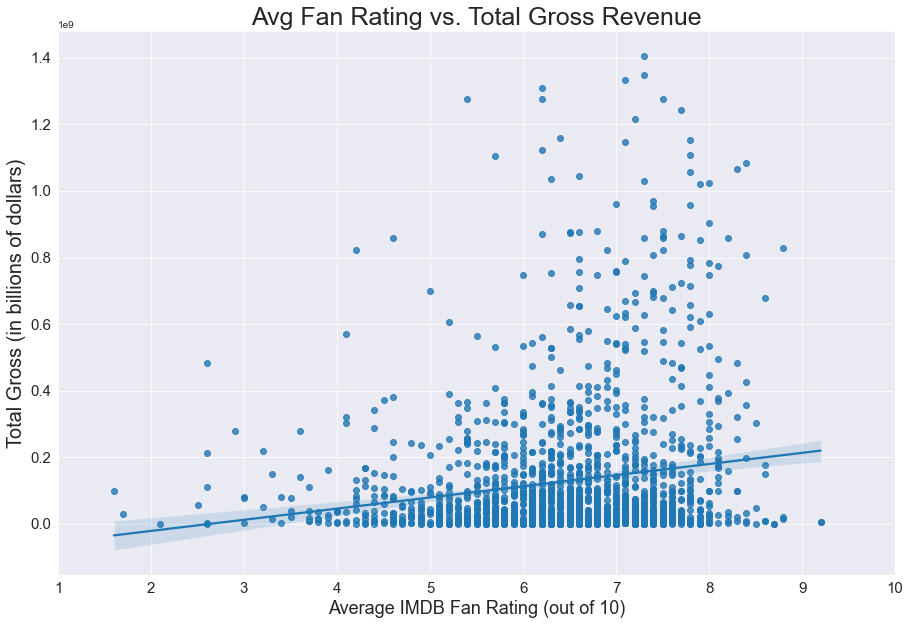

In [13]:
fig, ax = plt.subplots(figsize=(15,10))


regplot = sns.regplot(x='averagerating', y='total_gross', data=joined_df)


regplot.set_xlabel('Average IMDB Fan Rating (out of 10)', fontsize=18)
regplot.set_ylabel('Total Gross (in billions of dollars)', fontsize=20)
regplot.set_title('Avg Fan Rating vs. Total Gross Revenue', fontsize=25)

plt.xticks([1,2,3,4,5,6,7,8,9,10],fontsize=15)
plt.yticks(fontsize=15);

Analysis

Editing

In [14]:
joined_df.reset_index(inplace=True)

joined_df = pd.melt(joined_df, id_vars=['title'], value_vars=[genre for genre in genre_list])

joined_df.dropna(inplace=True)

# Make sure it looks right

joined_df.loc[joined_df['title'] == 'Inception']

,title,variable,value
1,Inception,Adventure,828300000.0
1800,Inception,Action,828300000.0
26986,Inception,Sci-Fi,828300000.0


# Second Graph

Second graph:

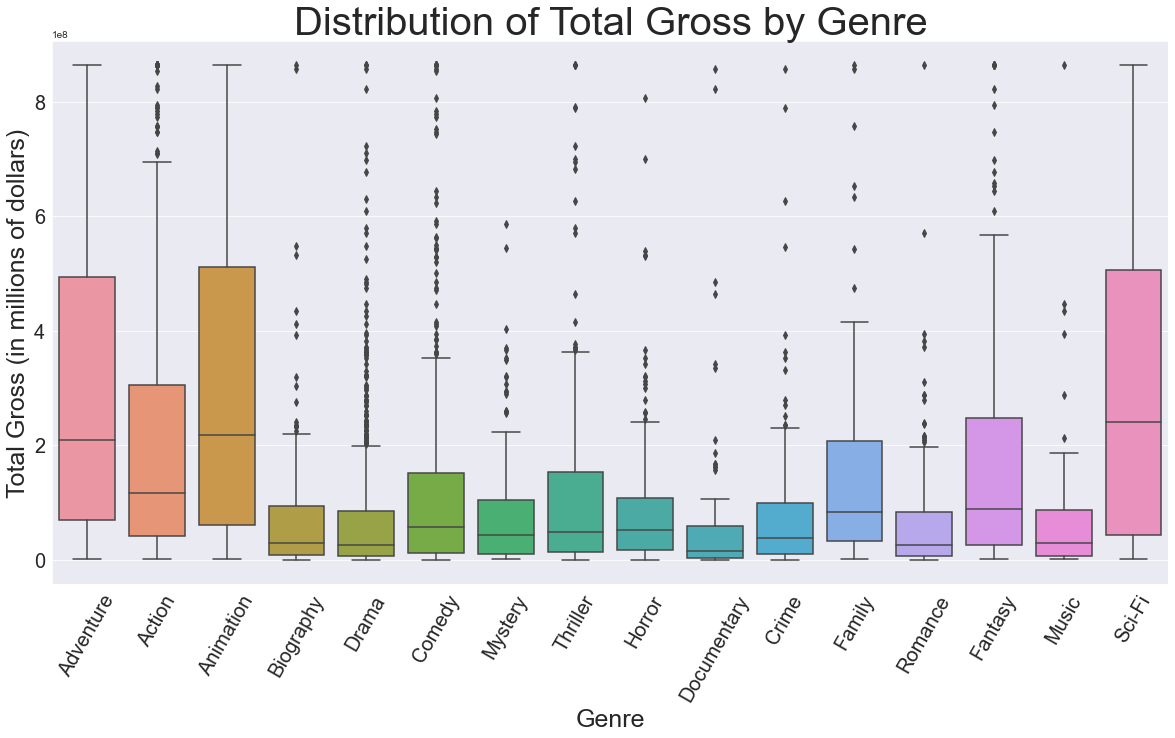

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

boxplot = sns.boxplot(x='variable', y='value', data=joined_df)

boxplot.set_xlabel('Genre', fontsize=25)
boxplot.set_ylabel('Total Gross (in millions of dollars)', fontsize=25)
boxplot.set_title('Distribution of Total Gross by Genre', fontsize=40)

plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=20);


# Third Graph

In [16]:
# Going back to our other dataset

movie_gross_date_df.head(3)

,title,studio,domestic_gross,foreign_gross,year,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,vote_average,vote_count
0,Toy Story 3,BV,415000000.0,652000000,2010,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,7.7,8340
1,Inception,WB,292600000.0,535700000,2010,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,8.3,22186
2,Shrek Forever After,P/DW,238700000.0,513900000,2010,38,"[35, 12, 14, 16, 10751]",10192,en,Shrek Forever After,15.041,2010-05-16,6.1,3843


# Clean up

In [17]:
# Drop NaNs

movie_gross_date_df.dropna(subset=['domestic_gross', 'foreign_gross'], inplace=True)

# Turn Foreign Gross into an integer

movie_gross_date_df['foreign_gross'] = pd.to_numeric(movie_gross_date_df['foreign_gross'], errors='coerce')

# Create total gross

movie_gross_date_df['total_gross'] = movie_gross_date_df['domestic_gross'] + movie_gross_date_df['foreign_gross']

# Winsorize at 10%

win_new = mstats.winsorize(movie_gross_date_df['total_gross'], limits=[0, 0.10])

movie_gross_date_df['total_gross_win'] = win_new

# Create Date column

movie_gross_date_df['Date'] = pd.to_datetime(movie_gross_date_df['release_date'])

# Drop irrelevant columns

movie_gross_date_df.drop(columns=['studio', 'domestic_gross', 'foreign_gross',
                                 'Unnamed: 0', 'genre_ids', 'id', 'original_language',
                                 'original_title', 'popularity', 'vote_average',
                                 'vote_count'], inplace=True)

# Reset index

movie_gross_date_df.set_index('title', inplace=True)


# Take a look !

movie_gross_date_df.head(3)

,year,release_date,total_gross,total_gross_win,Date
title,,,,,
Toy Story 3,2010,2010-06-17,1.067000e+09,375700000.0,2010-06-17
Inception,2010,2010-07-16,8.283000e+08,375700000.0,2010-07-16
Shrek Forever After,2010,2010-05-16,7.526000e+08,375700000.0,2010-05-16


In [18]:
# Make a function that turns date into a column

def get_season(date):
    date = str(date)
    month = int(date.split("-")[1])
    if (month > 11 or month <=3):
        return "Winter"
    elif (month == 4 or month == 5):
        return "Spring"
    elif (month >=6 and month <=9):
        return "Summer"
    else:
        return "Fall"

In [19]:
# Run it!

movie_gross_date_df['Season'] = movie_gross_date_df['Date'].map(get_season)
movie_gross_date_df.head(3)

,year,release_date,total_gross,total_gross_win,Date,Season
title,,,,,,
Toy Story 3,2010,2010-06-17,1.067000e+09,375700000.0,2010-06-17,Summer
Inception,2010,2010-07-16,8.283000e+08,375700000.0,2010-07-16,Summer
Shrek Forever After,2010,2010-05-16,7.526000e+08,375700000.0,2010-05-16,Spring


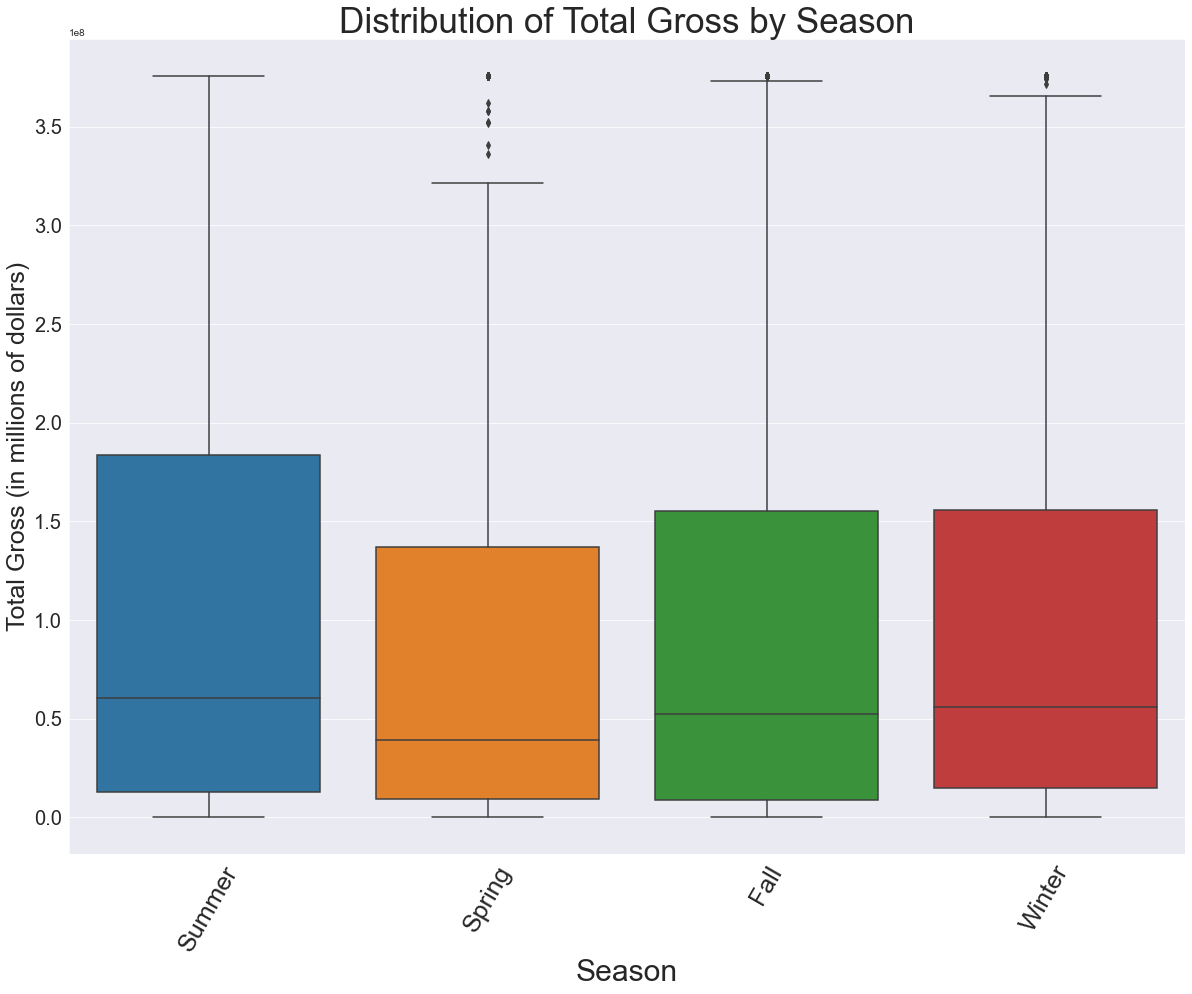

In [20]:
# Graph !

fig, ax = plt.subplots(figsize=(20,15))

boxplot_2 = sns.boxplot(x='Season', y='total_gross_win', data=movie_gross_date_df)

boxplot_2.set_xlabel('Season', fontsize=30)
boxplot_2.set_ylabel('Total Gross (in millions of dollars)', fontsize=25)
boxplot_2.set_title('Distribution of Total Gross by Season', fontsize=35)

plt.xticks(fontsize=25, rotation=60)
plt.yticks(fontsize=20);